# Code for "Non-unitary Coupled Cluster on Gate-based Quantum Computers"

This companion notebook is intended to provide access to the code used to generate results in the publication titled "Non-unitary Coupled Clusters on Gate-based Quantum Computers," as published in [arXiv:2406.11574 ](https://arxiv.org/abs/2406.11574). This work focuses on state preparation, aiming to efficiently prepare quantum states using both classical and quantum methods.

Many quantum algorithms rely on high-quality initial states for optimal performance. Efficiently preparing these states can significantly reduce the computational cost of probabilistic algorithms such as quantum phase estimation (QPE). Fortunately, in quantum chemistry applications, generating approximate wave functions for molecular systems is well-studied. Quantum computing stands to benefit from directly importing these classical methods into quantum circuits. In this work, we propose a state preparation method based on coupled cluster (CC) theory, a cornerstone of quantum chemistry on classical computers. Our approach incorporates mid-circuit measurements into the circuit construction.

This state preparation protocol involves:

1. Computing coupled cluster amplitudes using a classical quantum chemistry package,
2. Converting these amplitudes into rotation angles, described in Equation 9 of the paper,
3. Executing the circuit as illustrated in Figure 3 of the paper until all measurement outcomes are 0.

This notebook includes the code necessary to replicate the results presented in the publication.


## NUCCSD code

The primary goal of this method is to implement the state transformation:

$$
  \ket{\psi} \rightarrow \frac{e^{\alpha \hat{a}^{\dagger}_p \hat{a}_q} \ket{\psi}}{\|e^{\alpha \hat{a}^{\dagger}_p \hat{a}_q} \ket{\psi} \|}
$$

where $\alpha$ represents the classically computed CC amplitude. The full CC state is constructed using sequences of exponentiated cluster operators, achieved through trotterization.

Initially, the CC amplitudes are computed classically, as illustrated in the code cell below. This work specifically focuses on treating single and double excitation terms comprehensively, starting from unrestricted mean fields due to their compatibility with subsequent Jordan-Wigner mapping.

In [1]:
from tangelo.algorithms.classical import CCSDSolver

def unrestricted_ccsd_params(mol):
    """Compute the classical CCSD energy and amplitudes.

    Args:
        mol (SecondQuantizedMolecule): Self-explanatory.

    Returns:
        (array of floats, float): CC amplitudes and energy.   
    """
    
    solver = CCSDSolver(mol)
    e_uccsd = solver.simulate()
    t1, t2 = solver.solver.cc_fragment.t1, solver.solver.cc_fragment.t2

    params = uccsd_openshell_get_packed_amplitudes(
        t2[0], # alpha-alpha terms.
        t2[2], # beta-beta terms.
        t2[1], # alpa-beta terms.
        mol.n_active_ab_electrons[0],
        mol.n_active_ab_electrons[1],
        mol.n_active_mos[0],
        mol.n_active_mos[1],
        alpha_single_amplitudes=t1[0],
        beta_single_amplitudes=t1[1]
    )

    return params, e_uccsd

We first define the functions to create the circuit primitives, as defined in the article. Their purposes can be found in their respective docstrings.

In [2]:
from tangelo.linq import Gate, Circuit


def pre_factor_phase_gate(p):
    """Return a boolean if the circuit needs a phase gate to inject the
    appropriate parameter phase.

    Args:
        p (float): Parameter to implement in the circuit.

    Returns:
        bool: If we must consider a phase gate to inject parameter p.
    """    
    return 1 if p < 0. else 0

def prep(plus_qubits):
    """Prepare |+> qubits.
    
    Args:
        plus_qubits (iterable of int): Qubit indices of the |+> qubits.
    
    Returns:
        Circuit: Quantum circuit with Hadamard gates applied to |+> qubits.
    """
    return Circuit([Gate("H", i) for i in plus_qubits])


def single_exc(pq, plus_qubits, coeff_qubit, theta):
    """Single excitation CCSD circuit.
    
    The operator applied is a_p^{\dagger} a_q, assuming p > q.
    
    Args:
        pq (iterable of int): Indices representing the unoccupied and occupied spinorbitals.
        plus_qubits (iterable of int): Qubit indices of the |+> qubits.
        coeff_qubit (iterable of int): Qubit index for the coefficient.
        theta (float): Rotation angle to apply the proper amplitude.
    
    Returns:
        Circuit: Quantum circuit representing a single excitation term in CCSD.
    """

    sign = pre_factor_phase_gate(theta)
    rot = abs(theta)

    p, q = pq

    # We are working in the single-reference CC. The reference state is expected
    # to be a single reference state where lowest lying orbitals are filled
    # first.
    assert p > q

    plus_p, plus_q = plus_qubits

    gates = list()

    gates += [Gate("H", i) for i in plus_qubits]
    gates += [Gate("RY", coeff_qubit, parameter=rot, is_variational=True)]
    gates += [Gate("PHASE", coeff_qubit, parameter=sign*pi, is_variational=True)]

    gates += [
        Gate("CPHASE", p, parameter=-pi/2, control=plus_p),
        Gate("CPHASE", q, parameter=-pi/2, control=plus_q)
    ]

    # PQ excitation.
    gates += [Gate("CX", p, control=coeff_qubit)]
    gates += [Gate("CZ", i, control=coeff_qubit) for i in range(q+1, p)]
    gates += [Gate("CX", q, control=coeff_qubit)]

    gates += [
        Gate("CPHASE", p, parameter=pi/2, control=plus_p),
        Gate("CPHASE", q, parameter=pi/2, control=plus_q)
    ]

    gates += [
        Gate("CPHASE", plus_p, control=coeff_qubit, parameter=-pi/2),
        Gate("CPHASE", plus_q, control=coeff_qubit, parameter=pi/2)
    ]

    gates += [Gate("H", i) for i in plus_qubits]
    gates += [Gate("RY", coeff_qubit, parameter=-rot, is_variational=True)]

    gates += [Gate("MEASURE", q) for q in coeff_qubit+plus_qubits]

    return Circuit(gates)


def double_exc(pqrs, plus_qubits, coeff_qubit, theta):
    """Double excitation CCSD circuit.
    
    The operator applied is a_p^{\dagger} a_q a_r^{\dagger} a_s, assuming p > q and r > s.
    
    Args:
        pqrs (iterable of int): Indices representing the occupied and unoccupied spinorbitals (twice).
        plus_qubits (iterable of int): Qubit indices of the |+> qubits.
        coeff_qubit (int): Qubit index for the coefficient.
        theta (float): Rotation angle to apply the proper amplitude.
    
    Returns:
        Circuit: Quantum circuit representing a double excitation term in CCSD.
    """


    sign = pre_factor_phase_gate(theta)
    rot = abs(theta)

    p, q, r, s = pqrs

    # We are working in the single-reference CC. The reference state is expected
    # to be a single reference state where lowest lying orbitals are filled
    # first.
    assert p > q
    assert r > s

    plus_p, plus_q, plus_r, plus_s = plus_qubits

    gates = list()

    gates += [Gate("H", i) for i in plus_qubits]
    gates += [Gate("RY", coeff_qubit, parameter=rot, is_variational=True)]
    gates += [Gate("PHASE", coeff_qubit, parameter=sign*pi, is_variational=True)]

    gates += [
        Gate("CPHASE", p, parameter=-pi/2, control=plus_p),
        Gate("CPHASE", q, parameter=-pi/2, control=plus_q),
        Gate("CPHASE", r, parameter=-pi/2, control=plus_r),
        Gate("CPHASE", s, parameter=-pi/2, control=plus_s)
    ]

    # RS excitation.
    gates += [Gate("CX", s, control=coeff_qubit)]
    gates += [Gate("CZ", i, control=coeff_qubit) for i in range(s+1, r)]
    gates += [Gate("CX", r, control=coeff_qubit)]

    # PQ excitation.
    gates += [Gate("CX", q, control=coeff_qubit)]
    gates += [Gate("CZ", i, control=coeff_qubit) for i in range(q+1, p)]
    gates += [Gate("CX", p, control=coeff_qubit)]

    gates += [
        Gate("CPHASE", s, parameter=pi/2, control=plus_s),
        Gate("CPHASE", r, parameter=pi/2, control=plus_r),
        Gate("CPHASE", q, parameter=pi/2, control=plus_q),
        Gate("CPHASE", p, parameter=pi/2, control=plus_p)
    ]

    gates += [
        Gate("CPHASE", plus_p, control=coeff_qubit, parameter=-pi/2),
        Gate("CPHASE", plus_q, control=coeff_qubit, parameter=pi/2),
        Gate("CPHASE", plus_r, control=coeff_qubit, parameter=-pi/2),
        Gate("CPHASE", plus_s, control=coeff_qubit, parameter=pi/2)
    ]

    gates += [Gate("H", i) for i in plus_qubits]
    gates += [Gate("RY", coeff_qubit, parameter=-rot, is_variational=True)]

    gates += [Gate("MEASURE", q) for q in coeff_qubit+plus_qubits]

    return Circuit(gates)

Next, the CC amplitudes can be converted to rotation parameters $\theta$ through the equation

$$
  \frac{\cos^2{(\theta/2)} \ket{\psi} \pm \sin^2{(\theta/2)} \hat{a}_{p}^{\dagger} \hat{a}_q \ket{\psi}}{\sqrt{\cos^4{(\theta/2)} + \sin^4{(\theta/2)}}} \approx \left(I + \alpha \hat{a}_{p}^{\dagger} \hat{a}_q\right) \ket{\psi}.
$$

In [3]:
from math import pi

import numpy as np

def map_amps_to_ry_thetas(amps):
    """Convert CC amplitudes to RY rotation angles.
    
    Args:
        amps (float or array of float): CC amplitudes.
    
    Returns:
        float or array of float: RY rotation angles corresponding to the CC amplitudes.
    """
    amplitudes = np.array(amps, dtype=float)
    coeff = (amplitudes**2/(1-amplitudes**2))**(1/4)
    return np.sign(amplitudes)*2*np.arctan(coeff)

For example, the operator $e^{0.001 \hat{a}_6\hat{a}_3}$ can be mapped to a quantum circuit using the `map_amps_to_ry_thetas` and `single_exc` functions.

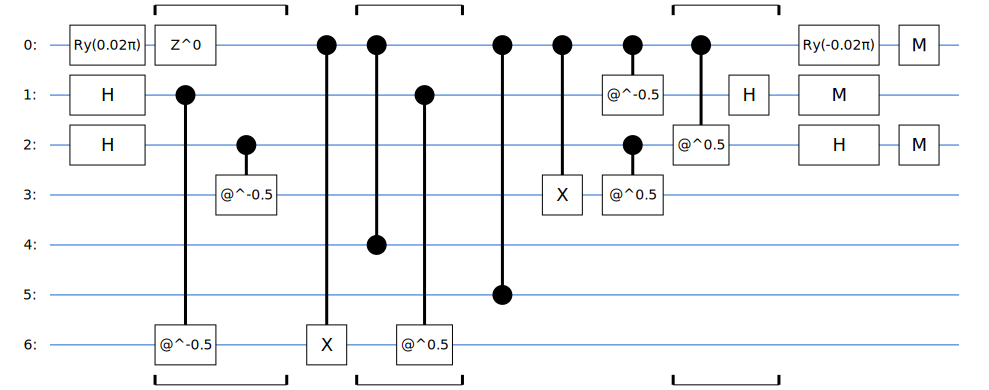

In [4]:
theta = map_amps_to_ry_thetas(0.001)
single_exc_circ = single_exc(pq=(6, 3), plus_qubits=(1,2), coeff_qubit=(0,), theta=theta)
single_exc_circ.draw()

This circuit describes the scenario where a cluster operator contains only a single operator. However, in routine quantum chemistry calculations, this situation is uncommon, and practitioners typically employ the first-order Suzuki-Trotter approximation:

$$
  \ket{\psi} = e^{T_1+T_2} \ket{\psi_0} \approx e^{T_1}e^{T_2} \ket{\psi_0},
$$

to decompose the exponentiated sum of operators into a product of exponentiated operators. While not mathematically exact, the errors resulting from this approximation are generally small. This principle extends to cluster operators, where coefficients typically represent small amplitudes.

In the following code cell, we define an ansatz `NUCCSD` that utilizes mid-circuit measurements to implement single and double cluster operators.

In [5]:
from collections import OrderedDict

from tangelo.toolboxes.ansatz_generator import Ansatz
from tangelo.toolboxes.qubit_mappings.statevector_mapping import get_reference_circuit
from tangelo.toolboxes.ansatz_generator._unitary_cc_openshell import uccsd_openshell_paramsize, uccsd_openshell_generator, uccsd_openshell_get_packed_amplitudes


class NUCCSD(Ansatz):
    """Construct non-unitary CC states on quantum circuits.
    
    Uses mid-circuit measurements to implement fermionic creation and annihilation
    operators, as well as performing amplitude injections. Only supports the Jordan-Wigner (JW)
    occupation mapping.
    
    Args:
        n_sos (int): Number of spin-orbitals.
        n_electrons (int): Number of electrons.
        up_then_down (bool): Flag indicating spin-orbital ordering.
        verbose (bool): Flag for verbose output.
    """


    def __init__(self, n_sos, n_electrons, up_then_down=False, verbose=False):

        if isinstance(n_sos, (tuple, list)) and len(n_sos) ==  2:
            self.n_sos_a, self.n_sos_b = n_sos
            self.n_alpha, self.n_beta = n_electrons
        elif isinstance(n_sos, int):
            assert n_sos % 2 == 0, "The total number of spin-orbitals should be even when reference is RHF or ROHF."
            self.n_sos_a = self.n_sos_b = n_sos // 2
        else:
            raise NotImplementedError

        if isinstance(n_electrons, (tuple, list)) and len(n_electrons) ==  2:
            self.uhf = True
            self.n_alpha, self.n_beta = n_electrons

            self.n_singles, self.n_doubles, _, _, _, _, _ = uccsd_openshell_paramsize(
                self.n_alpha, self.n_beta, self.n_sos_a, self.n_sos_b)
        elif isinstance(n_electrons, int):
            self.uhf = False
            self.n_alpha = self.n_beta = n_electrons // 2
            self.n_alpha += n_electrons % 2
        else:
            raise NotImplementedError

        self.n_singles, self.n_doubles, _, _, _, _, _ = uccsd_openshell_paramsize(
            self.n_alpha, self.n_beta, self.n_sos_a, self.n_sos_b)

        self.spin = self.n_alpha - self.n_beta

        self.up_then_down = up_then_down

        self.n_var_params = self.n_singles + self.n_doubles

        self.supported_reference_state = {"HF"}
        self.supported_initial_var_params = {"zeros", "ones", "random"}

        self.var_params_default = "zeros"
        self.reference_state = "HF"

        self.var_params = None
        self.circuit = Circuit()

        self.verbose = verbose

    @property
    def n_spinorbitals(self):
        return self.n_sos_a + self.n_sos_b

    @property
    def n_electrons(self):
        return self.n_alpha + self.n_beta

    @property
    def n_measure_gates(self):
        return self.circuit.counts.get("MEASURE", 0)

    @property
    def max_n_measure_gates(self):
        return 3*self.n_singles + 5*self.n_doubles

    def set_var_params(self, var_params=None):
        """Initialize variational parameters as ones, zeros, random numbers, or
        any other values.
        """

        if var_params is None:
            var_params = self.var_params_default

        if isinstance(var_params, str):
            var_params = var_params.lower()
            if (var_params not in self.supported_initial_var_params):
                raise ValueError(f"Supported keywords for initializing variational parameters: {self.supported_initial_var_params}")

            if var_params == "ones":
                applied_var_params = np.ones((self.n_var_params,), dtype=float)
            elif var_params == "zeros":
                applied_var_params = np.zeros((self.n_var_params,), dtype=float)
            elif var_params == "random":
                applied_var_params = (np.random.random((self.n_var_params,)) - 0.5) * pi
        else:
            applied_var_params = np.array(var_params)
            if applied_var_params.size != self.n_var_params:
                raise ValueError(f"Expected {self.n_var_params} variational parameters but "
                                 f"received {applied_var_params.size}.")
        self.var_params = applied_var_params
        return self.var_params

    def prepare_reference_state(self):
        """Return circuit preparing the desired reference wavefunction (HF)."""
        if self.reference_state not in self.supported_reference_state:
            raise ValueError(f"Only supported reference state methods are: {self.supported_reference_state}")

        return get_reference_circuit(n_spinorbitals=self.n_spinorbitals,
                                     n_electrons=self.n_electrons,
                                     mapping="JW",
                                     up_then_down=self.up_then_down,
                                     spin=self.spin)

    def build_circuit(self, var_params=None, cc_op=None, ccop_order=None):
        """Build and return the quantum circuit implementing the ansatz."""

        _ = self.set_var_params(var_params)

        n_qubits = self.n_spinorbitals

        # Ancilla qubit indices.
        single_coeff_qubit = (n_qubits,)
        single_plus_qubits = (n_qubits + 1, n_qubits + 2)
        double_coeff_qubit = (n_qubits,)
        double_plus_qubits = (n_qubits + 1, n_qubits + 2, n_qubits + 3, n_qubits + 4)

        if cc_op is None:
            # Last argument to False gives the non-unitary variant.
            cc_op = uccsd_openshell_generator(self.var_params,
                                              self.n_alpha, self.n_beta,
                                              self.n_sos_a, self.n_sos_b,
                                              anti_hermitian=False)

        # Initial HF circuit.
        self.circuit = self.prepare_reference_state()

        self.var_param_to_gate_index = dict()

        # Here we can change the order!
        if ccop_order is not None:
            cc_op_dict = OrderedDict()
            for term in ccop_order:
                cc_op_dict[term] = cc_op.terms[term]
        else:
            cc_op_dict = OrderedDict(cc_op.terms)

        for i, (term, param) in enumerate(cc_op_dict.items()):
            theta = map_amps_to_ry_thetas(param).real

            if len(term) == 2:
                pq = term[0][0], term[1][0]
                self.circuit += single_exc(pq, single_plus_qubits, single_coeff_qubit, theta)
                pass
            elif len(term) == 4:
                pqrs = term[0][0], term[1][0], term[2][0], term[3][0]
                self.circuit += double_exc(pqrs, double_plus_qubits, double_coeff_qubit, theta)
            else:
                raise RuntimeError("Unrecognized FermionOperator term.")

            # Will keep track of the first RY gate, the second one is at the
            # index i+2. Index is at len(circuit._variational_gates) - 3 because
            # 1 RY + PHASE + 1RYdag gates.
            self.var_param_to_gate_index[i] = len(self.circuit._variational_gates) - 3

        if self.verbose:
            resources = self.circuit.counts | {"n_qubits": self.circuit.width}
            print(f"Resource estimation: {resources}")

        return self.circuit

    def update_var_params(self, var_params):
        """Updating the value of variational parameters could be possible 
        to do here, but it is out of scope for this work.
        """
        pass

## Test set

The molecular set selected consists of small molecules, chosen specifically for testing the algorithm on emulators (classical computers). These simple molecules were also selected to verify the algorithm's accuracy on both closed-shell and open-shell systems.

In [6]:
molecules = {
    "H2": {"xyz": "H 0.0 0.0 0.0\nH 0.0 0.0 0.7414", "q": 0, "spin": 0},
    "H3": {"xyz": "H 0.0 0.0 0.0\nH 0.0 0.0 1.\nH 0.0 0.0 2.", "q": 0, "spin": 1},
    "H4": {"xyz": "H 0.0 0.0 0.0\nH 0.0 0.0 1.\nH 0.0 0.0 2.\nH 0.0 0.0 3.", "q": 0, "spin": 0},
    "LiH": {"xyz": "Li 0.0 0.0 0.0\nH 0.0 0.0 1.5949", "q": 0, "spin": 0},
    "BeH2": {"xyz": "Be 0.0 0.0 0.0\nH 0.0 0.0 1.3264\nH 0.0 0.0 -1.3264", "q": 0, "spin": 0},
    "BH3": {"xyz": "B 0.0 0.0 0.0\nH 0.0 1.19 0.0\nH 1.0306 -0.5950 0.0\nH -1.0306 -0.5950 0.0", "q": 0, "spin": 0},
    "NH3": {"xyz": "N 0.0 0.0 0.0\nH 0.0 -0.9377 -0.3816\nH 0.8121 0.4689 -0.3816\nH -0.8121 0.4689 -0.3816", "q": 0, "spin": 0},
    "H2O": {"xyz": "O 0.0 0.0 0.1173\nH 0.0 0.7572 -0.4692\nH 0.0 -0.7572 -0.4692", "q": 0, "spin": 0},
    "HF": {"xyz": "F 0.0 0.0 0.0\nH 0.0 0.0 0.9168", "q": 0, "spin": 0},
    "OH": {"xyz": "O 0.0 0.0 0.0\nH 0.0 0.0 0.9697", "q": 0, "spin": 1},
}

In the next cell, for each molecule, the CCSD solution is computed, the amplitudes are converted into rotation angles, circuits are constructed, and energy evaluations are performed.

In [7]:
from tangelo import SecondQuantizedMolecule
from tangelo.linq import get_backend
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping

# Qulacs is a fast emulator we can use with Tangelo.
backend = get_backend("qulacs")

for name, data in molecules.items():
    print(name)
    
    # Generate the qubit Hamiltonian.
    mol = SecondQuantizedMolecule(data["xyz"], q=data["q"], spin=data["spin"], basis="sto-3g", uhf=True)
    mapping = {
        "mapping": "JW", 
        "up_then_down": False, 
        "n_spinorbitals": mol.n_active_sos, 
        "n_electrons": mol.n_active_electrons, 
        "spin": mol.active_spin
    }
    quop = fermion_to_qubit_mapping(mol.fermionic_hamiltonian, **mapping)
    print(f"Mean-field energy: {mol.mf_energy}")

    # Compute the classical CC amplitudes, and map them to rotation parameters.
    initial_params, e_unrestricted_ccsd = unrestricted_ccsd_params(mol)
    print(f"CCSD energy: {e_unrestricted_ccsd}")

    # Instantiate the ansatz.
    ansatz = NUCCSD(mol.n_active_sos, mol.n_active_ab_electrons, up_then_down=mapping["up_then_down"], verbose=True)

    # Pass the rotation parameters to the ansatz.
    circ = ansatz.build_circuit(var_params=initial_params)
    print(f"Number of mid-circuit measurements: {ansatz.n_measure_gates}")

    # Perform an energy evaluation for the case where all mid-circuit measurement output state \ket{0}.
    e = backend.get_expectation_value(quop, circ, desired_meas_result="0"*ansatz.n_measure_gates)
    sucess_probability = circ._probabilities["0"*ansatz.n_measure_gates]

    # Print results.
    print(f"Circuit energy: {e}")
    print(f"Delta with the classical CC: {e_unrestricted_ccsd-e}")
    print(f"Probability of measuring all 0 in mid-circuit measurements: {sucess_probability}")
    print("\n")

H2
Mean-field energy: -1.1166843870768308
CCSD energy: -1.1372701746082805
Resource estimation: {'X': 2, 'H': 16, 'RY': 6, 'PHASE': 3, 'CPHASE': 24, 'CX': 8, 'CZ': 4, 'MEASURE': 11, 'n_qubits': 9}
Number of mid-circuit measurements: 11
Circuit energy: -1.1372693134556129
Delta with the classical CC: -8.611526676194359e-07
Probability of measuring all 0 in mid-circuit measurements: 0.815893647196254


H3
Mean-field energy: -1.5413964182579791
CCSD energy: -1.5683518645673808
Resource estimation: {'X': 3, 'H': 24, 'RY': 8, 'PHASE': 4, 'CPHASE': 36, 'CX': 12, 'CZ': 14, 'MEASURE': 16, 'n_qubits': 11}
Number of mid-circuit measurements: 16
Circuit energy: -1.5683495795366218
Delta with the classical CC: -2.2850307590527308e-06
Probability of measuring all 0 in mid-circuit measurements: 0.5689173128840068


H4
Mean-field energy: -2.0985459369980344
CCSD energy: -2.1663795201010387
Resource estimation: {'X': 4, 'H': 128, 'RY': 40, 'PHASE': 20, 'CPHASE': 192, 'CX': 64, 'CZ': 92, 'MEASURE': 84,